In [41]:
import os, sys
import numpy as np
from astropy import units, constants
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize, curve_fit
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d
from lmfit import Model
from matplotlib.gridspec import GridSpec
import lmfit
from lightkurve.lightcurve import LightCurve




COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/belugawhale/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

## PROPOSAL ID 16164
plt.rcParams['font.size']=18

def load_data(path):
    wavelength, flux, err = load_binned_data(os.path.join(path,'interp_between_1.npy'))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits


_, flare_orbits, flare_mask = np.load('/Users/belugawhale/Documents/AUMic/flare_mask2.npy',
                                      allow_pickle=True)

parula = np.load('/Users/belugawhale/parula_colors.npy')

distance = (9.72*units.pc).to(units.cm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
time=t[12:]-t0[0]

In [83]:
letter = 'a'
inp = np.load('/Users/belugawhale/Documents/AUMic/1s/counts{}.npy'.format(letter),
              allow_pickle=True).tolist()
counts = inp['counts']
linspace = inp['linspace']
time_summed = inp['time_summed']
timebins = inp['timebins']
bins = inp['bins']

d = np.load('/Users/belugawhale/Documents/AUMic/1s/data_{}.npy'.format(letter), allow_pickle=True)
w = d[0] + 0.0
f = d[1] + 0.0
e = d[2] + 0.0
iw = w[0] + 0.0

(10.0, 820.0)

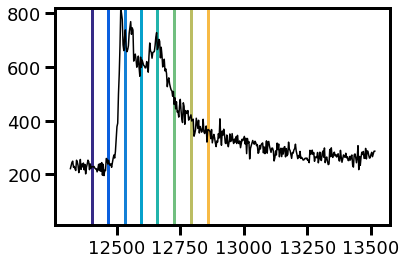

In [84]:
plt.plot(time[timebins[:-1]], np.nansum(time_summed, axis=1)[:-1], 'k')
x=0
xadd=30

if letter=='a':
    q = (iw>1221) & (iw<1230)
else:
    q = (iw>1203) & (iw<1210)

for i in linspace:
    plt.vlines(time[timebins[:-1]][i], 0, 1000, color=parula[x], lw=3)
    x += xadd
plt.ylim(10,820)

In [69]:
len(w), len(counts[0][linspace][0])

(16384, 16384)

(0.0, 5.0)

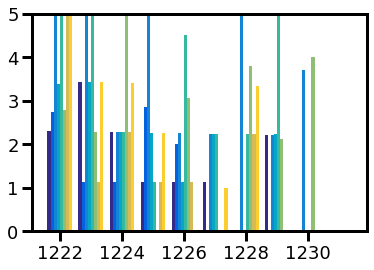

In [85]:
if letter == 'a':
    bins=np.arange(1221.5, 1232.5, 1)
else:
    bins=np.arange(1203-0.5, 1207.5, 1) 
out = plt.hist(counts[0][linspace][:,q].T, bins=bins, 
         weights=time_summed[linspace][:,q].T,
         density=False,
         lw=4, 
        color=parula[np.linspace(0,len(parula)-30,len(linspace), dtype=int)])
plt.ylim(0,5)

In [86]:
def histograms_only(counts, start_wavelength=1221.5):
    plt.figure(figsize=(14,4))

    fig, axes = plt.subplots(ncols=1, nrows=len(linspace), 
                             figsize=(8,20), sharey=True)
    axes = axes.reshape(-1)

    for i in range(len(axes)):
        out = axes[i].hist(counts[0][linspace][:,q].T, bins=bins, 
                       weights=time_summed[linspace][:,q].T,#/1e-12, 
                       density=False, #histtype='step',
                       lw=4, 
                       color=parula[np.linspace(0,len(parula)-30,len(linspace),dtype=int)])
        if i == 2:
            axes[i].set_ylabel('Counts [e s$^{-1}$]')
        if i == 7:
            axes[i].set_xlabel('Time [s]')
        axes[i].set_xlim(start_wavelength+i,start_wavelength+1+i)
        axes[i].set_xticks(np.linspace(start_wavelength+0.09+i,
                                       start_wavelength+1-0.09+i,len(linspace)))
        axes[i].set_xticklabels(timebins[linspace])
        axes[i].text(s=r'$\lambda$ = {} $\AA$'.format(start_wavelength+0.5+i), 
                     x=start_wavelength+0.05+i, y=7)
        if i < 4:
            axes[i].set_xticklabels([])
    plt.ylim(0,15)
    plt.show()
    return

<Figure size 1008x288 with 0 Axes>

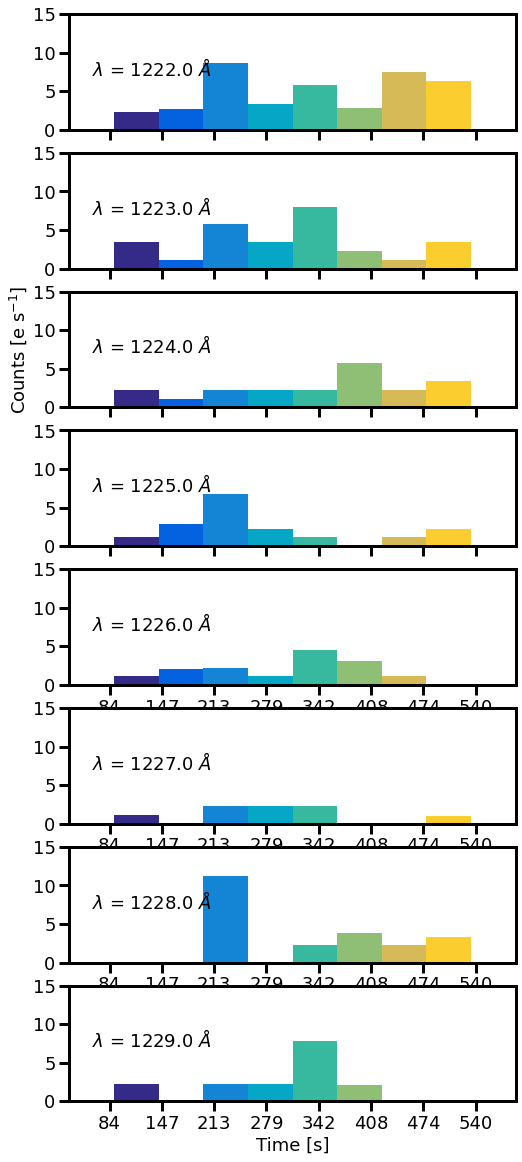

In [87]:
if letter=='a':
    histograms_only(counts)#, start_wavelength=1200-0.5)#1221.5)
else:
    histograms_only(counts, start_wavelength=1203-0.5)#1221.5)

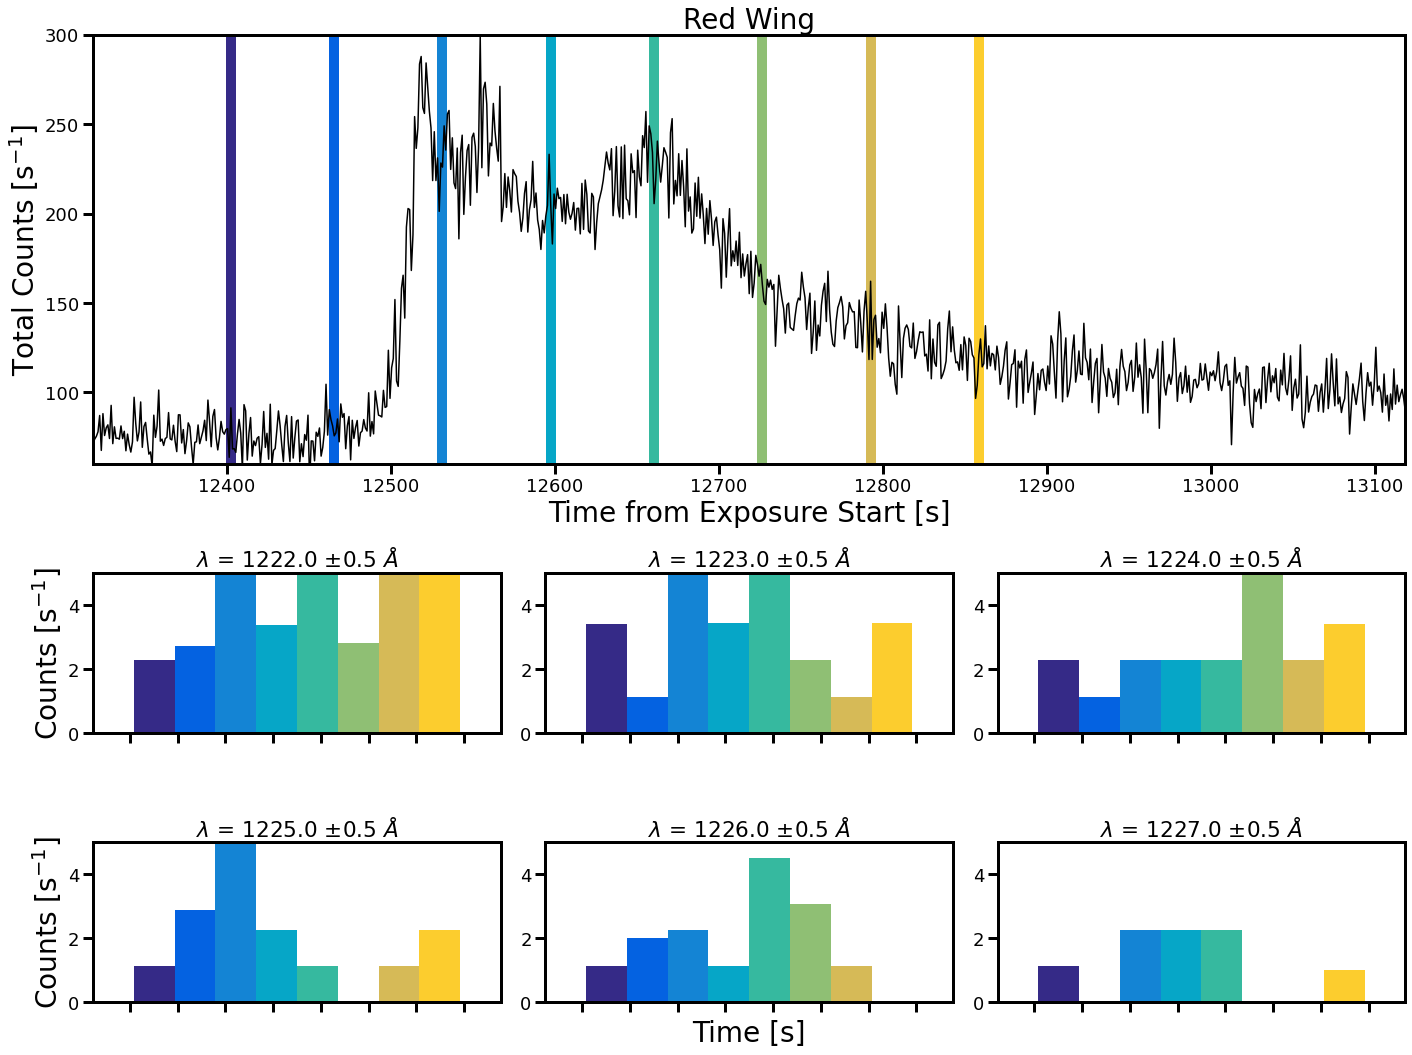

In [88]:
def main_figure(counts, start_wavelength=1221.5, ylim=[60,300]):
    outputs = []
    fig = plt.figure(tight_layout=True, figsize=(20,15))
    fig.set_facecolor('w')
    gs = GridSpec(ncols=3, nrows=4)

    ax = fig.add_subplot(gs[0:2, :])

    ax.plot(time, np.nansum(counts[1],axis=1), 'k')
            #np.trapz(counts, x=fwc.wavelength, axis=1), 'k')
    x=0
    for i in linspace:
        ax.vlines(time[timebins[:-1]][i], 0, 10000, 
                  color=parula[np.linspace(0,len(parula)-30,len(linspace),dtype=int)][x],
                  lw=10)
        x += 1

    ax.set_ylim(ylim)
    ax.set_ylabel('Total Counts [s$^{-1}$]', fontsize=28)
    ax.set_xlabel('Time from Exposure Start [s]', fontsize=28)
    ax.set_xlim(time[0],time[int(len(time)/1.5)])
    
    axes = []
    for i in range(3):
        axes.append(fig.add_subplot(gs[-2,i]))
    for i in range(3):
        axes.append(fig.add_subplot(gs[-1,i]))

    for i in range(len(axes)):
        out = axes[i].hist(counts[0][linspace][:,q].T, bins=bins, 
                           weights=time_summed[linspace][:,q].T,#/1e-12, 
                           density=False, #histtype='step',
                           lw=4, 
                           color=parula[np.linspace(0,len(parula)-30,len(linspace),dtype=int)])
        outputs.append(out)
        
        if i == 0 or i==3:
            axes[i].set_ylabel('Counts [s$^{-1}$]', fontsize=28)
        if i == 4:
            axes[i].set_xlabel('Time [s]', fontsize=28)

        axes[i].set_xlim(start_wavelength+i,start_wavelength+1+i)
        axes[i].set_xticks(np.linspace(start_wavelength+0.09+i,
                                       start_wavelength+1-0.09+i,len(linspace)))
        axes[i].set_xticklabels([])
        #axes[i].set_xticklabels(timebins[linspace])

        axes[i].set_title(r'$\lambda$ = {} $\pm 0.5$ $\AA$'.format(start_wavelength+0.5+i))
        axes[i].set_ylim(0,5)
        axes[i].set_rasterized(True)
    return fig, outputs

save = True

if letter == 'b':
    fig, outputs = main_figure(counts, start_wavelength=1203-0.5, ylim=[0,220])
    fig.axes[0].set_title('Blue Wing', fontsize=28)
    suffix = 'blue'
else:
    fig, outputs = main_figure(counts)
    fig.axes[0].set_title('Red Wing', fontsize=28)
    suffix = 'red'
#if save:
#    fig = plt.savefig('/Users/arcticfox/Desktop/Orrall-Zirker_{}.png'.format(suffix), dpi=300,
#                      rasterize=True, bbox_inches='tight')

In [75]:
outputs = np.zeros((len(linspace),len(bins)-1))
for i in range(len(counts[0][linspace][:,q])):
    out = np.histogram(counts[0][linspace][:,q][i], bins=bins, 
                       weights=time_summed[linspace][:,q][i])
    outputs[i] = out[0]

(12450.0, 12750.0)

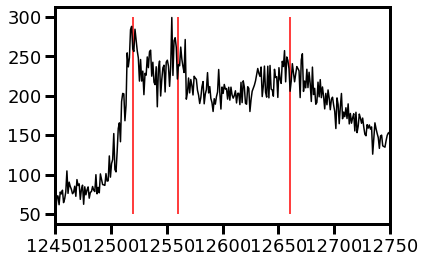

In [77]:
plt.plot(time, np.nansum(counts[1],axis=1), 'k')
plt.vlines(12660, 50, 300, 'r')
plt.vlines(12520, 50, 300, 'r')
plt.vlines(12560, 50, 300, 'r')
plt.xlim(12450,12750)

In [400]:
np.save('/Users/arcticfox/Documents/AUMic/1s/counts{}.npy'.format(letter), 
        {'counts':counts, 
         'linspace':linspace,
         'time_summed':time_summed,
         'timebins':timebins,
         'bins':bins})

## Look at -- F(1205.67-1208.67)/F(1222.67-1225.67)

In [135]:
d = np.load('/Users/belugawhale/Desktop/data_a.npy', allow_pickle=True)
w = d[0] + 0.0
f = d[1] + 0.0
e = d[2] + 0.0
iw = w[0] + 0.0

q2 = ((iw>=1205.) & (iw<=1208.))#((iw>=1222.) & (iw<=1225.))
trap2 = np.trapz(f[:,q2], x=w[:,q2], axis=1)

In [136]:
iw

array([1211.18824227, 1211.19820557, 1211.20816887, ..., 1374.39700738,
       1374.40697068, 1374.41693398])

In [137]:
d = np.load('/Users/belugawhale/Desktop/data_b.npy', allow_pickle=True)
w = d[0] + 0.0
f = d[1] + 0.0
e = d[2] + 0.0
iw = w[0] + 0.0

q1 = ((iw>=1205.) & (iw<=1208.))
trap1 = np.trapz(f[:,q1], x=w[:,q1], axis=1)

In [138]:
iw

array([1211.15824227, 1211.16820557, 1211.17816887, ..., 1374.36700738,
       1374.37697068, 1374.38693398])

In [139]:
hdu = fits.open('/Users/belugawhale/Documents/AUMic/1s/split_lebb01sdq_1261_x1d.fits')

In [140]:
hdu[1].data['WAVELENGTH']

array([[1211.15824227, 1211.16820557, 1211.17816887, ..., 1374.36700738,
        1374.37697068, 1374.38693398]])